In [22]:
path = '/home/arunava'
#****************************To be Change to reproduce ou result*********************************************

# location of the data and where to store iamge feature image
path_output_chd = path+'/VQA_Med'    

input_vqa_train = 'train_dataset_pickle/c1_mixed_train_dataset_df.pkl'
input_vqa_valid ='valid_dataset_pickle/c1_val_dataset_df.pkl'

img_feat_train = 'train_dataset_pickle/c1-mixed-train-image-feature.pickle'
img_feat_valid ='valid_dataset_pickle/c1-valid-image-feature.pickle'

input_test = 'test_dataset_pickle/C1_test_dataset_df.pkl'
img_feat_test = 'test_dataset_pickle/vgg19-test-image-feature.pickle'



In [23]:
import easydict
opt = easydict.EasyDict({
        "SEED":97,
        "BATCH_SIZE": 64,
        "VAL_BATCH_SIZE": 64,
        "NUM_OUTPUT_UNITS": 45,
        "MAX_QUESTION_LEN": 25,
        "IMAGE_CHANNEL": 1984,
        "INIT_LEARNING_RATE": 1e-4,
        "LAMNDA":0.0001,
        "MFB_FACTOR_NUM":5,
        "MFB_OUT_DIM":1000,
        "BERT_UNIT_NUM":768,
        "BERT_DROPOUT_RATIO":0.3,
        "MFB_DROPOUT_RATIO":0.1,
        "NUM_IMG_GLIMPSE":2,
        "NUM_QUESTION_GLIMPSE":2,
        "IMG_FEAT_SIZE":1,
        "IMG_INPUT_SIZE":224,
        "NUM_EPOCHS":100,
    })

In [24]:
import easydict
import nltk
import numpy as np
import random
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from transformers import BertTokenizer
from transformers import BertModel
import time
import re
from torchinfo import summary
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate import bleu_score
import os
import matplotlib.pyplot as plt
import nltk
import copy
import pandas as pd
import json

from transformers import VisualBertModel, VisualBertConfig
from transformers import AutoTokenizer, AutoModel



In [25]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device',device)

device cuda:0


In [26]:
nltk.download('punkt')

seed_value = opt.SEED
np.random.seed(seed_value)
random.seed(seed_value)
torch.manual_seed(seed_value) # return <torch._C.Generator object at 0x7f71cdf7a3d0>
torch.cuda.manual_seed(seed_value) 
torch.cuda.manual_seed_all(seed_value)
torch.backends.cudnn.enabled = False
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

[nltk_data] Downloading package punkt to /home/arunava/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [27]:
class VqaDataset(data.Dataset):
    '''
        Main class use to retrieve our dataset from pickle file.
    '''

    def __init__(self, input_dir, input_vqa, img_feat_vqa, transform=None, phase = 'train'):
        # print('vqa_path',input_dir+'/'+input_vqa)
        # print('feat_path',input_dir+'/'+img_feat_vqa)
        self.input_dir = input_dir
        self.vqa = np.load(input_dir+'/'+input_vqa, allow_pickle=True )
        self.img_feat_vqa = np.load(input_dir+'/'+img_feat_vqa, allow_pickle=True )
        self.vocab_size = None
        self.phase = phase
        # print('vqa',self.vqa)
        # print('img_feat_vqa',type(self.img_feat_vqa))
   

    def __getitem__(self, idx):

        vqa = self.vqa
        img_feat_vqa = self.img_feat_vqa
        image_id = vqa['image_id'].values[idx]
        image_feat = torch.Tensor(img_feat_vqa[image_id])
        sample = { 'image_feature':image_feat ,  } 
        if (self.phase == 'train'):
            ans2idc_a = vqa['labels_a'].values[idx]
            ans2dic_b = vqa['labels_b'].values[idx]
            answer_a = vqa['answer_a'].values[idx]
            answer_b = vqa['answer_b'].values[idx]
            question_a = vqa['question_a'].values[idx]
            question_b = vqa['question_b'].values[idx]
            sample['label_a'] = ans2idc_a
            sample['label_b'] = ans2dic_b
            sample['answer_a'] = answer_a
            sample['answer_b'] = answer_b
            sample['question_a'] = question_a
            sample['question_b'] = question_b
            sample['lamda'] = vqa['lamda'].values[idx]

        elif (self.phase == 'valid'):
            qst2dic = vqa['Question'].values[idx]  
            answer = vqa['Answer'].values[idx]
            label = vqa['labels'].values[idx]
            sample['question'] = qst2dic
            sample['answer'] = answer
            sample['label'] = label
        
        else:
            sample['image_id'] = image_id
            sample['question'] = vqa['Question'].values[idx]
            
            
        return sample

    def __len__(self):

        return len(self.vqa)


In [28]:
def get_loader(input_dir, input_vqa_train, input_vqa_valid, img_feat_train, img_feat_valid, batch_size, num_workers,size=228):
    '''
        Load our dataset with dataloader for the train and valid data
    '''

    vqa_dataset = {
        'train': VqaDataset(
            input_dir=input_dir,
            input_vqa=input_vqa_train,
            img_feat_vqa=img_feat_train,
            phase = 'train'),
        'valid': VqaDataset(
            input_dir=input_dir,
            input_vqa=input_vqa_valid,
            img_feat_vqa=img_feat_valid,
            phase = 'valid')}
    

    data_loader = {
        phase: torch.utils.data.DataLoader(
            dataset=vqa_dataset[phase],
            batch_size=batch_size,
            shuffle=True,
            num_workers=num_workers,
            )
        for phase in ['train','valid']}

    return data_loader

In [29]:
class BERTokenizer():

    def __init__(self,opt):
        # Load the BERT tokenizer
        # self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
        self.opt = opt
    #pre-process the text data
    def text_preprocessing(self, text):

        # Remove trailing whitespace
        text = re.sub(r'\s+', ' ', text).strip()

        return text


    # Create a function to tokenize a set of texts
    def preprocessing_for_bert(self, data):
        """Perform required preprocessing steps for pretrained BERT.
        @param    data (np.array): Array of texts to be processed.
        @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
        @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                    tokens should be attended to by the model.
        """
        # Create empty lists to store outputs
        input_ids = []
        attention_masks = []
        MAX_LEN = self.opt.MAX_QUESTION_LEN
        # For every sentence...
        for sent in data:
            
            encoded_sent = self.tokenizer.encode_plus(
                text=self.text_preprocessing(sent),  # Preprocess sentence
                add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
                max_length=MAX_LEN,                  # Max length to truncate/pad
                pad_to_max_length=True,         # Pad sentence to max length
                #return_tensors='pt',           # Return PyTorch tensor
                truncation=True,
                return_attention_mask=True      # Return attention mask
                )
            
            # Add the outputs to the lists
            input_ids.append(encoded_sent.get('input_ids'))
            attention_masks.append(encoded_sent.get('attention_mask'))

        # Convert lists to tensors
        input_ids = torch.tensor(input_ids)
        attention_masks = torch.tensor(attention_masks)

        inputs = { 'input_ids' : input_ids, 'attention_mask': attention_masks }

        return inputs


In [30]:
class VisualBertClassification(nn.Module):
    def __init__(self,opt,vocab_size=512,layers=6,n_heads=8):
        super(VisualBertClassification,self).__init__()
        VBconfig = VisualBertConfig( visual_embedding_dim=512,num_hidden_layers = layers, num_attention_heads = n_heads, hidden_size = 2048)
        self.opt = opt
        # self.tokenizer = BERTokenizer(self.opt)
        self.tokenizer = BertTokenizer.from_pretrained('./data/raw/bertvocab/v2/bert-medvqa/')
        self.model = VisualBertModel(VBconfig)
        self.classifier = nn.Linear(VBconfig.hidden_size,45)

    def forward(self,visual_embeds,questions):
        
        # print('visual_embeds',visual_embeds.shape)
        # visual_embeds = visual_embeds.transpose(1,2)
        # print('vocab_size',len(self.tokenizer))
        # print('visual_embeds',visual_embeds.shape)
        # inputs = self.tokenizer.preprocessing_for_bert(questions)
        inputs = self.tokenizer(questions,return_tensors="pt",padding="max_length",max_length=opt.MAX_QUESTION_LEN).to(device)
        visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long).to(device)
        # print('visual_token_type_ids',visual_token_type_ids.shape)
        visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.float).to(device)
        # print('visual_attention_mask',visual_attention_mask.shape)
        
        inputs.update(
            {
                "visual_embeds": visual_embeds,
                "visual_token_type_ids": visual_token_type_ids,
                "visual_attention_mask": visual_attention_mask,
                "output_attentions":True
            }
        ) 

        inputs['input_ids'] = inputs['input_ids'].to(device)
        # inputs['token_type_ids'] = inputs['token_type_ids'].to(device)
        inputs['attention_mask'] = inputs['attention_mask'].to(device)
        inputs['visual_token_type_ids'] = inputs['visual_token_type_ids'].to(device)
        inputs['visual_attention_mask'] = inputs['visual_attention_mask'].to(device)

        outputs = self.model(**inputs)
        # print('outputs',outputs['pooler_output'].shape)

        last_hidden_state = outputs.last_hidden_state
        prediction = self.classifier(outputs['pooler_output'])
        prediction = F.log_softmax(prediction, -1)
        return prediction

In [31]:
def load_checkpoint(model, optimizer, filename=None): 
    # Note: Input model & optimizer should be pre-defined. This routine only updates their states. 
    start_epoch = 0 
    if os.path.isfile(filename): 
        print("=> loading checkpoint '{}'".format(filename)) 
        checkpoint = torch.load(filename) 
        start_epoch = checkpoint['epoch'] 
        model.load_state_dict(checkpoint['state_dict']) 
        optimizer.load_state_dict(checkpoint['optimizer']) 
        print("=> loaded checkpoint '{}' (epoch {})" .format(filename,
                                                            checkpoint['epoch'])) 
    else: print("=> no checkpoint found at '{}'".format(filename)) 
    return model, optimizer, start_epoch


In [32]:
def mixup_criterion_vqa(criterion, pred_a, pred_b, a_a, a_b, lam):
    # print(lam * criterion(pred_a, a_a))
    # print((1 - lam) * criterion(pred_b, a_b))
    # print(lam * criterion(pred_a, a_a) + (1 - lam) * criterion(pred_b, a_b))
    return lam * criterion(pred_a, a_a) + (1 - lam) * criterion(pred_b, a_b)



In [33]:
def accuracy(output, target_a, target_b, lam, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
   
    maxk = max(topk)
    batch_size = target_a.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
   

    
    if target_a.dim() == 2: # multians option
        _, target = torch.max(target, 1)
    
    correct_a = pred.eq(target_a.view(1,-1).expand_as(pred))
    correct_b = pred.eq(target_b.view(1,-1).expand_as(pred))


    

    # print(pred.eq(target_a))

    # correct += (lam * pred.eq(target_a.data).cpu().sum().float()
    #                 + (1 - lam) * pred.eq(target_b.data).cpu().sum().float())


    res = []
    for k in topk:
        correct_k = lam*correct_a[:k].reshape(-1).float().sum(0) + (1-lam) * correct_b[:k].reshape(-1).float().sum(0)

        
        res.append((correct_k / batch_size))
   
    return res

In [34]:
def get_bleu_score(predicted, true_ans_a,true_ans_b,lam):
    path_output_change = path_output_chd
    with open(path_output_change+'/c1_answer_classes.json', 'r') as j:
        answer_classes_dict = json.load(j)
    score_a = 0.0
    score_b = 0.0
    assert (len(predicted) == len(true_ans_a))
    assert (len(predicted) == len(true_ans_b))
    ans_keys = list(answer_classes_dict.keys())
    ans_values = list(answer_classes_dict.values())
    

    for pred, true_ans in zip(predicted, true_ans_a):
        index_ans = ans_values.index(pred)
        score_a += sentence_bleu([true_ans.split(' ')], ans_keys[index_ans].split(' '), smoothing_function=bleu_score.SmoothingFunction().method2)

    for pred, true_ans in zip(predicted,true_ans_b):
        index_ans = ans_values.index(pred)

        score_b += sentence_bleu([true_ans.split(' ')], ans_keys[index_ans].split(' '), smoothing_function=bleu_score.SmoothingFunction().method2)
    

    score = lam * score_a + (1-lam)* score_b
    
    return score/len(true_ans_a)


In [35]:
def accuracy_valid(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
   
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
   

    
    if target.dim() == 2: # multians option
        _, target = torch.max(target, 1)
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0)
        res.append((correct_k / batch_size))
   
    return res


In [36]:
def get_bleu_score_valid(predicted, true_ans_text):
    path_output_change = path_output_chd
    with open(path_output_change+'/c1_answer_classes.json', 'r') as j:
        answer_classes_dict = json.load(j)
    score = 0.0
    assert (len(predicted) == len(true_ans_text))
    ans_keys = list(answer_classes_dict.keys())
    ans_values = list(answer_classes_dict.values())
    

    for pred, true_ans in zip(predicted, true_ans_text):
        index_ans = ans_values.index(pred)
        
        score += sentence_bleu([true_ans.split(' ')], ans_keys[index_ans].split(' '), smoothing_function=bleu_score.SmoothingFunction().method2)

    return score/len(true_ans_text)



In [37]:
since = time.time()

best_acc1 = 0.0
best_acc5 = 0.0

best_epoch = 0

list_train_loss_per_epoch = []
list_valid_loss_per_epoch = []

list_train_acc1_per_epoch = []
list_valid_acc1_per_epoch = []

In [38]:
model = VisualBertClassification( opt=opt ).to(device)
criterian = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(),lr = opt.INIT_LEARNING_RATE,weight_decay=opt.LAMNDA)

input_dir =  path_output_chd 
input_vqa_train = input_vqa_train 
input_vqa_valid = input_vqa_valid

img_feat_train =  img_feat_train
img_feat_valid = img_feat_valid

saved_dir =  path_output_chd


num_epochs = opt.NUM_EPOCHS
image_size = opt.IMG_INPUT_SIZE
num_workers = 0
batch_size = opt.BATCH_SIZE


In [39]:
vqa = np.load(input_dir+'/'+input_vqa_train, allow_pickle=True )

In [40]:
vqa

image_id  \
0                 synpic33990   
1                 synpic27913   
2                 synpic52990   
3                 synpic49802   
4                 synpic27745   
...                       ...   
6395  synpic60523_synpic25649   
6396  synpic21598_synpic60523   
6397  synpic19353_synpic17223   
6398  synpic35908_synpic44105   
6399  synpic17223_synpic49274   

                                           image_path_a  \
0     /home/arunava/VQA_Med_2019_Dataset/Train/Image...   
1     /home/arunava/VQA_Med_2019_Dataset/Train/Image...   
2     /home/arunava/VQA_Med_2019_Dataset/Train/Image...   
3     /home/arunava/VQA_Med_2019_Dataset/Train/Image...   
4     /home/arunava/VQA_Med_2019_Dataset/Train/Image...   
...                                                 ...   
6395  /home/arunava/VQA_Med_2019_Dataset/Train/Image...   
6396  /home/arunava/VQA_Med_2019_Dataset/Train/Image...   
6397  /home/arunava/VQA_Med_2019_Dataset/Train/Image...   
6398  /home/arunava/VQA_Med_2019_Dataset/Train/Image...   
6399  /home/arunava/VQA_Med_2019_Dataset/Train/Image...   

                                           image_path_b  \
0     /home/arunava/VQA_Med_2019_Dataset/Train/Image...   
1     /home/arunava/VQA_Med_2019_Dataset/Train/Image...   
2     /home/arunava/VQA_Med_2019_Dataset/Train/Image...   
3     /home/arunava/VQA_Med_2019_Dataset/Train/Image...   
4     /home/arunava/VQA_Med_2019_Dataset/Train/Image...   
...                                                 ...   
6395  /home/arunava/VQA_Med_2019_Dataset/Train/Image...   
6396  /home/arunava/VQA_Med_2019_Dataset/Train/Image...   
6397  /home/arunava/VQA_Med_2019_Dataset/Train/Image...   
6398  /home/arunava/VQA_Med_2019_Dataset/Train/Image...   
6399  /home/arunava/VQA_Med_2019_Dataset/Train/Image...   

                                             question_a  \
0                          is this a t1 weighted image?   
1               what is the mr weighting in this image?   
2          what type of contrast did this patient have?   
3                                    is this a ct scan?   
4                 was iv contrast given to the patient?   
...                                                 ...   
6395            what type of imaging modality is shown?   
6396                       is this a t1 weighted image?   
6397                      what imaging method was used?   
6398  what imaging modality was used to take this im...   
6399              in what modality is this image taken?   

                                             question_b  \
0                          is this a t1 weighted image?   
1               what is the mr weighting in this image?   
2          what type of contrast did this patient have?   
3                                    is this a ct scan?   
4                 was iv contrast given to the patient?   
...                                                 ...   
6395            with what modality is this image taken?   
6396            what type of imaging modality is shown?   
6397              in what modality is this image taken?   
6398  what type of imaging modality is used to acqui...   
6399                              is this an mri image?   

                        answer_a              answer_b  labels_a  labels_b  \
0                             no                    no         1         1   
1                             t1                    t1        12        12   
2                             iv                    iv        16        16   
3                             no                    no         1         1   
4                            yes                   yes         5         5   
...                          ...                   ...       ...       ...   
6395          ct w/contrast (iv)       xr - plain film         7         3   
6396                          no    ct w/contrast (iv)         1         7   
6397                  mammograph            mammograph         9         9   
6398  ct

In [41]:
data_loader = get_loader(
        input_dir = input_dir , 
        input_vqa_train = input_vqa_train, 
        input_vqa_valid = input_vqa_valid,
        img_feat_train = img_feat_train, 
        img_feat_valid = img_feat_valid,
            batch_size = batch_size, 
            num_workers = num_workers,
            size = image_size )

In [42]:
for epoch in range(opt.NUM_EPOCHS):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)
    
    for phase in ['train','valid']:
        # print('phase',phase)
        if phase == 'train':
            model.train()
        else: 
            model.eval()

        running_loss = 0.0
        top1_acc = 0
        top5_acc = 0

        bleu = 0

        batch_step_size = len(data_loader[phase].dataset) / batch_size
        # print('batch_step_size',batch_step_size)
        for batch_idx, batch_sample in enumerate(data_loader[phase]):
            # print('data loader',batch_idx)
            # print('batch_Sample',batch_sample)
            if phase == 'train':
                question_a = batch_sample['question_a']#.to(device)
                question_b = batch_sample['question_b']
                labels_a = batch_sample['label_a'].to(device)
                labels_b = batch_sample['label_b'].to(device)
                label_answer_a = batch_sample['answer_a']#.to(device)
                label_answer_b = batch_sample['answer_b']
                # lam = batch_sample['lamda'][0]
                lam = 0.185757

            elif phase == 'valid':
                question = batch_sample['question']
                answer = batch_sample['answer']
                labels = batch_sample['label'].to(device)

            image = batch_sample['image_feature'].to(device)
            # # print('imagee',image.shape)
            # questions = batch_sample['question']
            # labels = batch_sample['label'].to(device)
            # label_answer_text = batch_sample['answer_text']

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                
                if phase == 'train':
                    # inputs_a = tokenizer
                    output_a=model(image,question_a)
                    output_b=model(image,question_b)

                    output = (lam * output_a) + ((1 - lam) * output_b)
                    # print('output',output.shape)
                    _,preds = torch.max(output,1)
                    loss = mixup_criterion_vqa(criterian, output_a, output_b, labels_a, labels_b, lam)
                    # print('loss',loss)
                    
                    loss.backward()
                    # print('loss',loss.item())
                    optimizer.step()
                    # print('hello')            
                elif phase == 'valid':
                    output = model(image,question)
                    _,preds = torch.max(output,1)
                    loss = criterian(output,labels)





                # _,preds = torch.max(output,1)

                # loss = criterian(output,labels)

                # if phase == 'train':
                #     loss.backward()
                #     optimizer.step()
            # print('loss item',loss.item())
            running_loss += loss.item()
            # print('runnning loss',running_loss)


            # acc1,acc5 = accuracy(output.data,labels.data,topk=(1,5))

            # top1_acc += acc1
            # top5_acc += acc5

            # b = get_bleu_score(preds, label_answer_text)
            # bleu += b
            
            if phase == 'train':
                #exact match score
                acc1, acc5 = accuracy(output.data, labels_a.data, labels_b.data, lam, topk=(1, 5))
                # print('acc1',acc1)
                # print('acc5',acc5)
                top1_acc += acc1
                top5_acc += acc5
                # print('top1_acc',top1_acc)
                # bleu score
                b = get_bleu_score(preds, label_answer_a,label_answer_b,lam)
                # print('b',b)
                bleu += b

            elif phase == 'valid':
                    #exact match score
                    acc1, acc5 = accuracy_valid(output.data, labels.data, topk=(1, 5))
                    top1_acc += acc1
                    top5_acc += acc5
                    # bleu score
                    b = get_bleu_score_valid(preds, answer)
                    bleu += b

            # print('batch_idx',batch_idx)
            if batch_idx % 10 == 0:
                print('| {} SET | Epoch [{:02d}/{:02d}], Step[{:04d}/{:04d}], Loss: {:.4f}, Top 1 Acc: {:.4f}, Top 5 Acc: {:.4f}, Bleu: {:.4f}'.format(phase.upper(), epoch+1, num_epochs, batch_idx, int(batch_step_size), loss.item(), acc1, acc5, b))#Acc: {:.4f},Bleu: {:.4f},acc, b

        # print('batch_step_size',batch_step_size)
        epoch_loss = running_loss/batch_step_size
        # print('epoch_loss',epoch_loss)
        epoch_acc1 = top1_acc/batch_step_size
        # print('epoch_acc1',epoch_acc1)
        epoch_acc5 = top5_acc/batch_step_size
        # print('epoch_acc5',epoch_acc5)
        epoch_blue = bleu/batch_step_size
            
        #save the loss and accuracy for train and valid
        if phase =='train':
            # print('epoch_loss',epoch_loss)
            list_train_loss_per_epoch.append(epoch_loss)
            list_train_acc1_per_epoch.append(epoch_acc1)
            
        else:
            
            list_valid_loss_per_epoch.append(epoch_loss)
            list_valid_acc1_per_epoch.append(epoch_acc1)
            

        print('{} Loss: {:.4f} Top 1 Acc: {:.4f} Top 5 Acc: {:.4f} Bleu: {:.4f}'.format(
            phase, epoch_loss, epoch_acc1,epoch_acc5, epoch_blue))
        

        # deep copy the model
        if phase == 'valid' and epoch_acc1 > best_acc1: #or epoch_acc5 > best_acc5 ):
            best_acc1 = epoch_acc1
            best_acc5 = epoch_acc5
            best_epoch = epoch
            best_model_wts = copy.deepcopy(model.state_dict())



Epoch 0/99
----------
| TRAIN SET | Epoch [01/100], Step[0000/0100], Loss: 3.8673, Top 1 Acc: 0.0567, Top 5 Acc: 0.0879, Bleu: 0.1230
| TRAIN SET | Epoch [01/100], Step[0010/0100], Loss: 2.6969, Top 1 Acc: 0.2089, Top 5 Acc: 0.6730, Bleu: 0.1242
| TRAIN SET | Epoch [01/100], Step[0020/0100], Loss: 2.7444, Top 1 Acc: 0.1025, Top 5 Acc: 0.5967, Bleu: 0.1639
| TRAIN SET | Epoch [01/100], Step[0030/0100], Loss: 2.8026, Top 1 Acc: 0.2170, Top 5 Acc: 0.6065, Bleu: 0.1290
| TRAIN SET | Epoch [01/100], Step[0040/0100], Loss: 3.0179, Top 1 Acc: 0.1279, Top 5 Acc: 0.6083, Bleu: 0.0761
| TRAIN SET | Epoch [01/100], Step[0050/0100], Loss: 2.7080, Top 1 Acc: 0.2402, Top 5 Acc: 0.6817, Bleu: 0.1428
| TRAIN SET | Epoch [01/100], Step[0060/0100], Loss: 2.7076, Top 1 Acc: 0.3096, Top 5 Acc: 0.6609, Bleu: 0.1841
| TRAIN SET | Epoch [01/100], Step[0070/0100], Loss: 2.6754, Top 1 Acc: 0.1748, Top 5 Acc: 0.6632, Bleu: 0.1357
| TRAIN SET | Epoch [01/100], Step[0080/0100], Loss: 2.7477, Top 1 Acc: 0.2656, To

In [43]:
def make_plot(history, epoch_max, path_output_chd, type_plot='loss'):
    train = history['train']
    valid = history['valid']
    fig, ax = plt.subplots()
    epochs = range(epoch_max)
    
    
    if type_plot=='loss':
        plt.plot(epochs, train, '-r', lw=2, label='Training loss')
        plt.plot(epochs, valid, '-b',lw=2, label='validation loss')
        plt.legend(borderaxespad=0.)
        plt.title('Training and Validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.savefig(path_output_chd+'/imgs/loss.png')
        
    elif type_plot == 'acc1':
        ltrain = []
        lvalid = []
        for i in range(len(train)):
            ltrain.append(train[i].to('cpu').numpy().tolist())
        for i in range(len(valid)):
            lvalid.append(valid[i].to('cpu').numpy().tolist())
    
        plt.plot(epochs, ltrain, '-r', lw = 2, label='Training Top 1 Accuracy')
        plt.plot(epochs, lvalid, '-b', lw = 2, label='validation Top 1 Accuracy')
        plt.legend(borderaxespad=0.)
        plt.title('Training and Validation Top 1 Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Top 1 Accuracy')
        plt.savefig(path_output_chd+'/imgs/acc1.png')

    elif type_plot == 'acc5':
        ltrain = []
        lvalid = []
        for i in range(len(train)):
            ltrain.append(train[i].to('cpu').numpy().tolist())
        for i in range(len(valid)):
            lvalid.append(valid[i].to('cpu').numpy().tolist())
        plt.plot(epochs, ltrain, '-r', lw = 2, label='Training Top 5 Accuracy')
        plt.plot(epochs, lvalid, '-b', lw = 2, label='validation Top 5 Accuracy')
        plt.legend(borderaxespad=0.)
        plt.title('Training and Validation Top 5 Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Top 5 Accuracy')
        plt.savefig(path_output_chd+'/imgs/acc5.png')
    else:
        ltrain = []
        lvalid = []
        for i in range(len(train)):
            ltrain.append(train[i].to('cpu').numpy().tolist())
        for i in range(len(valid)):
            lvalid.append(valid[i].to('cpu').numpy().tolist())
        plt.plot(epochs, ltrain, '-r', lw = 2, label='Training blue')
        plt.plot(epochs, lvalid, '-b', lw = 2, label='validation blue')
        plt.legend(borderaxespad=0.)
        plt.title('Training and Validation blue')
        plt.xlabel('Epochs')
        plt.ylabel('Blue')
        plt.savefig(path_output_chd+'/imgs/blue.png')

    
    
    plt.show()

Training complete in 190m 34s
Best val Top 1 Acc: 0.491846, Top 5 Acc: 0.896154


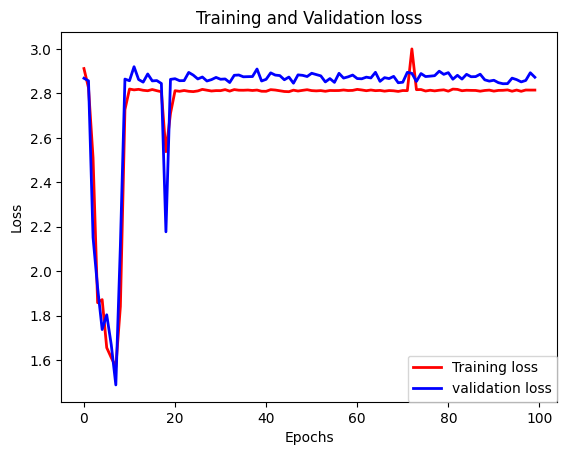

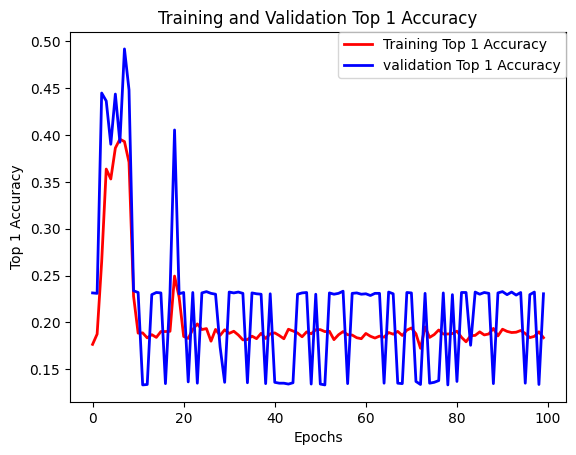

In [44]:
history_loss = {'train':list_train_loss_per_epoch, 'valid':list_valid_loss_per_epoch}
history_acc1 = {'train':list_train_acc1_per_epoch, 'valid':list_valid_acc1_per_epoch}

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
print('Best val Top 1 Acc: {:4f}, Top 5 Acc: {:4f}'.format(best_acc1,best_acc5))

#plot the loss and accuracy for train and valid
make_plot(history_loss, num_epochs, input_dir, type_plot='loss')
make_plot(history_acc1, num_epochs,input_dir, type_plot='acc1')


In [45]:
# load best model weights
model.load_state_dict(best_model_wts)
model.load_state_dict(best_model_wts)
state = {'epoch': best_epoch, 
        'state_dict': model.state_dict(), 
        'optimizer': optimizer.state_dict(), 
            'loss':epoch_loss,'valid_accuracy': best_acc1}

full_model_path =saved_dir+'/mixed_model_state_seed_97.tar'

torch.save(state, full_model_path)


In [46]:
vqa = np.load('/home/arunava/VQA_Med/test_dataset_pickle/test_dataset_df.pkl', allow_pickle=True )

input_test = 'test_dataset_pickle/test_dataset_df.pkl'
